In [1]:
# download dataset Monthly Sunspots
!wget -O monthly-sunspots.csv https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv --quiet

In [2]:
import pandas as pd
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as pyplot
import lightgbm as lgb
import warnings
from dateutil.relativedelta import *

In [3]:
# remove warnings from pandas and LightGBM (use with caution)
warnings.filterwarnings('ignore')

In [4]:
# set plot size for matplotlib
plt.rcParams["figure.figsize"] = (15,8)

In [5]:
# load data
data = pd.read_csv("./monthly-sunspots.csv")

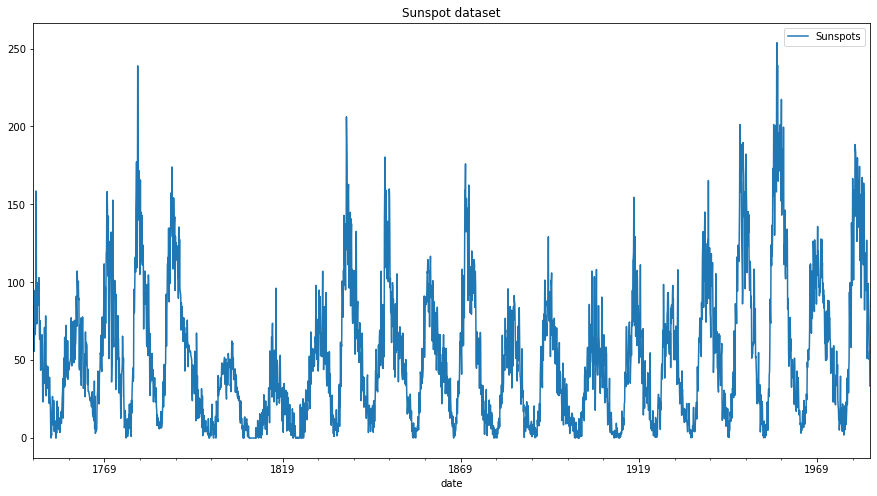

In [6]:
# visualizing the dataset
data['date'] = pd.to_datetime(data['Month'])
data.drop('Month', axis=1, inplace=True)
data.plot(x='date', y='Sunspots', title='Sunspot dataset')

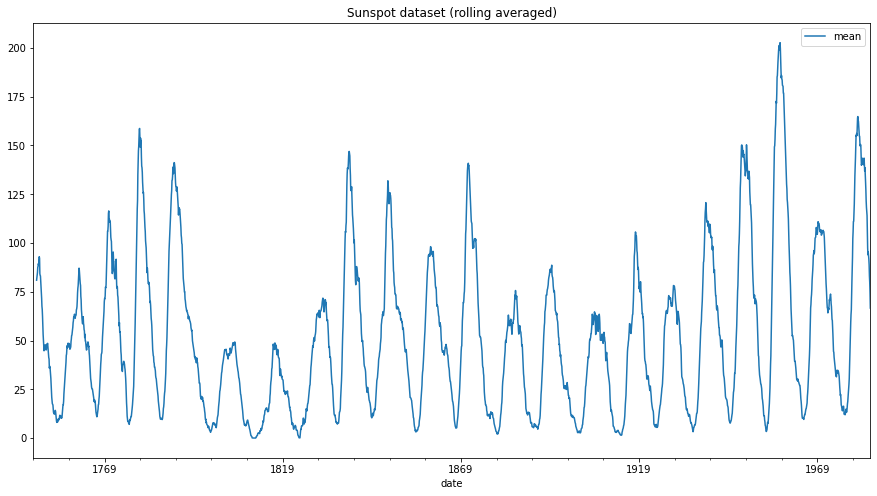

In [7]:
# plot smoothed out version of the dataset (yearly)
data['mean'] = data['Sunspots'].rolling(window=12).mean().dropna()
data.plot(x='date', y='mean', title='Sunspot dataset (rolling averaged)')
data.drop('mean', axis=1, inplace=True)

In [8]:
# check dataset range
print("Dataset goes from {} to {}".format(data.date.min(), data.date.max()))

Dataset goes from 1749-01-01 00:00:00 to 1983-12-01 00:00:00


In [9]:
# set lags to be created as extra features for seasonality
lags = [1, 2, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 36, 40, 48]

# create lag features
for lag in lags:
  data['lag_' + str(lag)] = data.Sunspots.shift(lag)

In [10]:
# add categorical seasonality features

# based on date
data['month'] = data.date.dt.month
data['year'] = data.date.dt.year
data['quarter'] = data.date.dt.quarter

# based on series sequence
# this just goes from 1 to len(data) in squence
data['seq'] = list(data.index + 1)

In [11]:
# deep copy full dataset
data_cp = data.copy(deep=True)

# set training data and first entry of test data
data = data[data['date'] <= pd.to_datetime('1981-01-01')]

In [12]:
# de-trend timeseries by differentiating (can also be achieved by using diff() from Pandas)
data['Sunspots'] = data['Sunspots'] - data['Sunspots'].shift(1)

In [13]:
# set train and test sets, here test set is just a single row (1981-01-01)
# we will start from this date and forecast 24 months in the future
train = data[data['date'] < pd.to_datetime('1981-01-01')]
test = data[(data['date'] >= pd.to_datetime('1981-01-01'))]

In [14]:
# drop NaN, which are the first 2 years of data (due to creation of lags)
train.dropna(axis=0, inplace=True)

In [15]:
# training loop to do final data processing and train the models

# set GBM params
# aside from the ones task-specific, everything will be left out as default
param = {'objective': 'regression', 
         'metric': 'mse'}

# create dictionary to store all the models for each month 
models_dict = {}

# iterate from 1 to 24, which will create 24 GBMs for each of the 24 months
for i in range(1, 25):
  print("Fitting model {}".format(i))

  # shift label on training set
  # by doing this we will force the model to learn how to forecast at t+i
  train_iter = train.copy()
  train_iter['Sunspots'] = train.Sunspots.shift(-i)

  # drop last i rows from training sets
  # these have NaN value due to the shift made to the labels
  train_iter.dropna(axis=0, inplace=True)

  # define LightGBM Dataset class
  # create training set
  train_data = train_iter.loc[:, ~train_iter.columns.isin(['date', 'Sunspots'])]
  train_data = lgb.Dataset(train_data, label=train_iter.Sunspots, feature_name=list(train_data), categorical_feature=['month', 'year', 'quarter'], free_raw_data=False)

  # model training
  # set number of training loops
  num_round = 100
  model = lgb.train(param, train_set=train_data, num_boost_round=num_round)

  # save model to dict
  models_dict.update({i: model})

Fitting model 1
Fitting model 2
Fitting model 3
Fitting model 4
Fitting model 5
Fitting model 6
Fitting model 7
Fitting model 8
Fitting model 9
Fitting model 10
Fitting model 11
Fitting model 12
Fitting model 13
Fitting model 14
Fitting model 15
Fitting model 16
Fitting model 17
Fitting model 18
Fitting model 19
Fitting model 20
Fitting model 21
Fitting model 22
Fitting model 23
Fitting model 24


In [16]:
# Forecast for upcoming 24 months using test data (entry for 1981-01-01)
# all 24 models created above will be used, each one for t+i
forecast = []
for i in range(1, 25):
  # get entry from test set, which is just a single row and predict
  test_data = test.iloc[0, ~test.columns.isin(['date', 'Sunspots'])]
  prediction = models_dict[i].predict(test_data.values.reshape(1, -1))
  forecast.append(prediction[0])

In [17]:
# set date range for filtering test dataframe
start_forecast = '1981-01-01'
end_forecast = pd.to_datetime(start_forecast) + relativedelta(months=+24)

# create test_df from data_cp which has all the original data in it (no differentiation)
test_df = data_cp[(data_cp['date'] >= start_forecast) & (data_cp['date'] < end_forecast)]

# add forecast to DataFrame before adding back trend
test_df['Sunspots'] = forecast

# create single dataframe with all data (train + test)
data = data.append(test_df)

# undo differentiation on data and save results on data DF
x, x_diff = data_cp['Sunspots'].iloc[0], data['Sunspots'].iloc[1:]
data['Sunspots_trended'] = np.r_[x, x_diff].cumsum().astype(int)

In [18]:
# filter out all 24 months from forecast and get the respective DataFrame
data_test_dates = data[data['date'].isin(test_df.date)]

# skip first row since it's duplicated because of the preprocessing done
data_test_dates = data_test_dates.iloc[1:]

# add original labels from data_cp, which was untouched from the start
data_test_dates['label'] = data_cp[(data_cp['date'] >= start_forecast) & (data_cp['date'] < end_forecast)]['Sunspots'].values

Text(0.5, 1.0, 'True values vs Forecast')

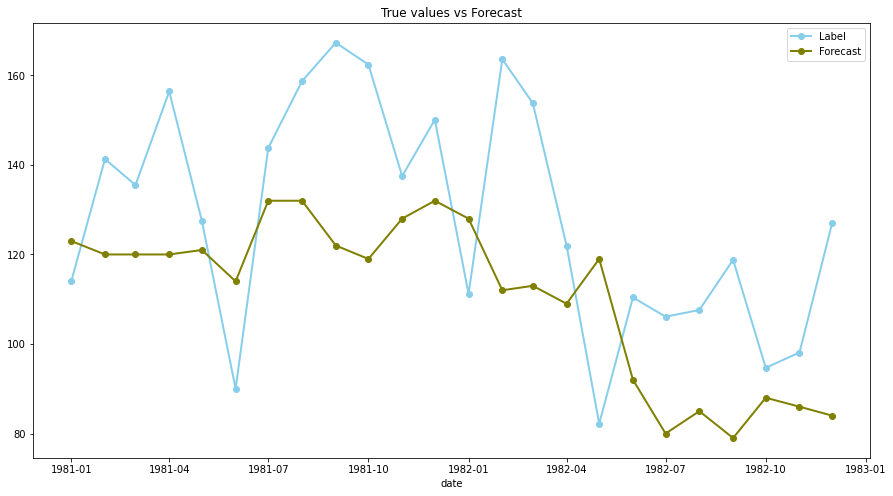

In [30]:
# multiple line plot to see forecast vs true labels
pyplot.plot('date', 'label', data=data_test_dates, marker='.', markersize=12, color='skyblue', linewidth=2, label='Label') 
pyplot.plot('date', 'Sunspots_trended', data=data_test_dates, marker='.', markersize=12, color='olive', linewidth=2, label='Forecast')
pyplot.legend()
pyplot.xlabel('date')
pyplot.title("True values vs Forecast")

Text(0.5, 1.0, 'Full data + forecast')

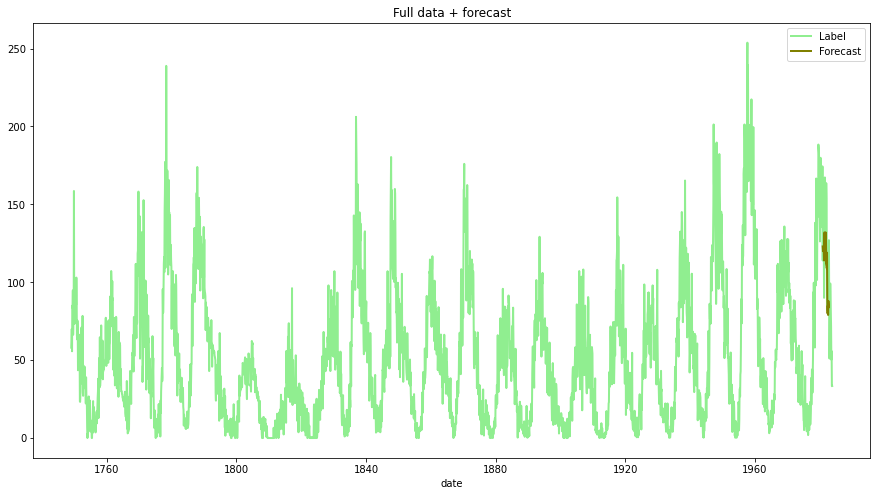

In [39]:
# multiple line plot
pyplot.plot('date', 'Sunspots', data=data_cp, marker='', markerfacecolor='blue', markersize=12, color='lightgreen', linewidth=2, label="Label")
pyplot.plot('date', 'Sunspots_trended', data=data_test_dates, marker='', color='olive', linewidth=2, label="Forecast")
pyplot.legend()
pyplot.xlabel('date')
pyplot.title("Full dataset + Forecast")

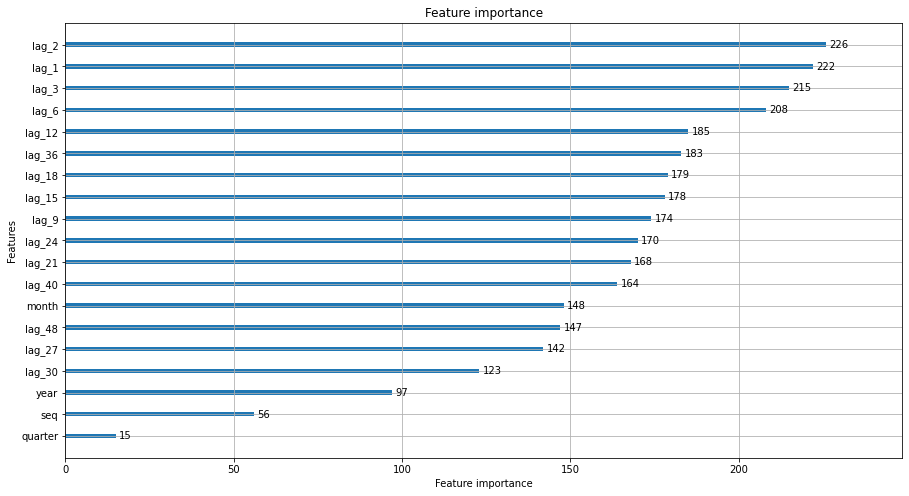

In [21]:
lgb.plot_importance(models_dict[3])

In [22]:
# get feature importance from all 24 models
feature_importance_df = pd.DataFrame()

for index, model in models_dict.items():  
  iter = pd.DataFrame(data=model.feature_importance()).T
  iter.columns = model.feature_name()
  iter.index = [index]
  feature_importance_df = feature_importance_df.append(iter)

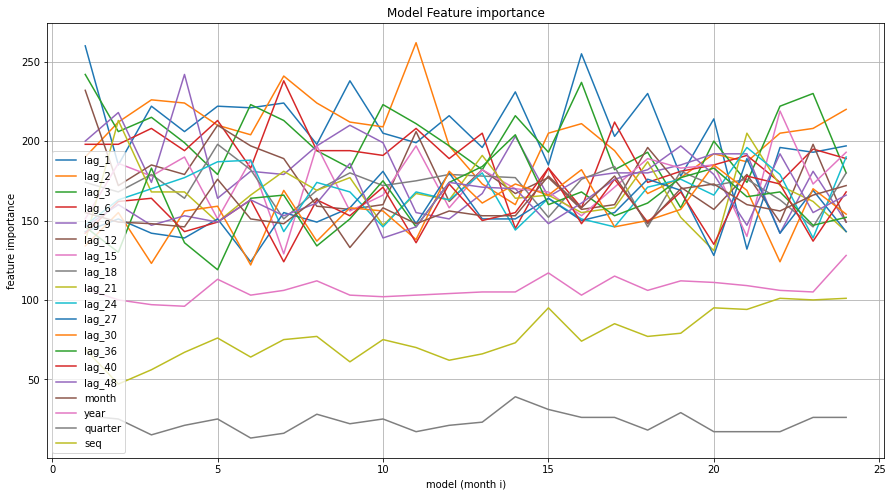

In [43]:
# plot feature importance for each model (model 1 is for month 1, model 24 is for month 24 respectively)
feature_importance_df.plot()
pyplot.title("Model Feature importance")
pyplot.xlabel('model (month i)')
pyplot.ylabel('feature importance')
pyplot.grid()